## Raw pupil data preprocessing

### Reference

Major referenced papers:
1. Total VREcall, https://dl-acm-org.libproxy1.nus.edu.sg/doi/10.1145/3534615 
2. GazeR: A Package for Processing Gaze Position and Pupil Size Data. https://pubmed.ncbi.nlm.nih.gov/32291732/ 
3. ComputationalMR. https://github.com/eth-ait/ComputationalMR 
4. Preprocessing pupil data: guidelines and code. https://link.springer.com/content/pdf/10.3758/s13428-018-1075-y.pdf Github repository https://github.com/ElioS-S/pupil-size. Check this when have time, seems no need to integrate it now because it is too complicated but won't improve my LHIPA score much.

### Background
This script is the initial data processing trial, and now is the pipeline trial.

In [1]:
import pandas as pd
import math, os, pywt
import numpy as np
import ipynb.fs
from matplotlib import pyplot as plt
from numba import jit
from numpy.lib.stride_tricks import sliding_window_view
# from .defs.PreprocessedPupilDataIPAComputing import normalize_timestamp, calc_lhipa, modmax

def plotter(ax, data1, data2, param_dict):
    out = ax.plot(data1, data2, **param_dict)
    return out

### Read, synchronize, and merge raw data
Read data from synchronized left and right eye data.

In [2]:
read_left_file_path = '../Data/RawData/08-09-13-02-lowlux-TWOBACK/left2D_88Hz.csv'
read_right_file_path = '../Data/RawData/08-09-13-02-lowlux-TWOBACK/right2D_102Hz.csv'
%store read_left_file_path
%store read_right_file_path

Stored 'read_left_file_path' (str)
Stored 'read_right_file_path' (str)


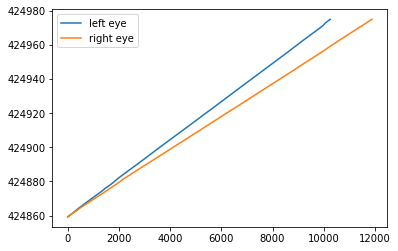

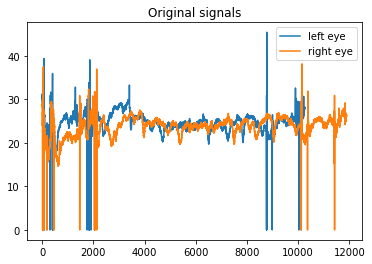

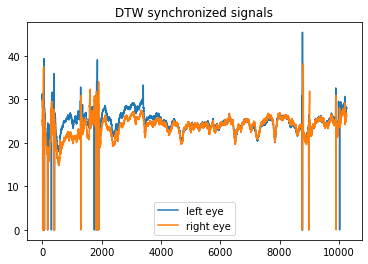

,Timestamp,Confidence,Diameter,Event
0,424859.221620,0.619354,27.031742,default
1,424859.233974,0.549891,27.787770,default
2,424859.242680,0.626268,28.112017,default
3,424859.253524,0.592996,27.508861,default
4,424859.269089,0.621343,27.594951,default
...,...,...,...,...
11882,424974.967029,NaN,NaN,sitting
11883,424974.974336,NaN,NaN,sitting
11884,424974.985883,NaN,NaN,sitting
11885,424974.996229,NaN,NaN,sitting


In [3]:
# Get data and sampling rate from synchronizing file.
%run ./LeftRightEyesSyncData.ipynb

SAMPLING_RATE = SR
data = df_to_raw_preprocess

df = data[['Timestamp','Confidence','Diameter','Event']].copy()
df

### De-blinking and remove data with low confidence

#### Extending blinks

In [4]:
## Check how David Linderbaure's group deal with the blinks. Use confidence to identify blinks. They removed the data within 200ms. However, they did not interpolate the eliminated ones.
## Here I clean data before and after 200ms of blinks. The input is the numpy data list of the "confidence" conlumn. Then return a list that marks which indecies are blinks. 
def mark_blinks(data):
    # Variables initialization:
    blinks = []
    
    min_num_blinks = 2
    num_samples = len(data)
    i = 0
    min_conf = 0.25
    
    duration_sample_remove_ms = 200
    num_samples_removed = int(math.ceil(SAMPLING_RATE / (1000 / duration_sample_remove_ms)))
    
    # Find blinks, identified by low confidence data.##TODO: get the data into a class.
    while i < num_samples:
        if data[i] < min_conf and i < num_samples - 1:
            runner = 1
            next_data = data[i + runner]
            while next_data < min_conf:
                runner = runner + 1
                if i + runner >= num_samples:
                    break
                next_data = data[i + runner]
            
            if runner >= min_num_blinks:
                blinks.append((i, runner))
                
            i = i + runner  # This blink is over, update to the next.
        else:
            i = i + 1
    
    # Mark data before and after 200ms of blinks.
    blink_markers = np.ones(num_samples)
    for i in range(len(blinks)):
        blink_index = blinks[i][0]
        blink_length = blinks[i][1]
        
        for j in range(0, blink_length):
            blink_markers[blink_index + j] = 0
        
        for j in range(0, num_samples_removed):
            decrement_index = blink_index - j
            increment_index = blink_index + blink_length + j
            
            # Check the boundary conditions.
            if decrement_index >=0:
                blink_markers[decrement_index] = 0
            
            if increment_index < num_samples:
                blink_markers[increment_index] = 0
    
    return blink_markers

In [5]:
## Get confidence column.
data_conf = df['Confidence'].copy()
data_conf

0        0.619354
1        0.549891
2        0.626268
3        0.592996
4        0.621343
           ...   
11882         NaN
11883         NaN
11884         NaN
11885         NaN
11886         NaN
Name: Confidence, Length: 11887, dtype: float64

In [6]:
blink_markers = mark_blinks(data=data_conf)
blink_markers

array([1., 1., 1., ..., 1., 1., 1.])

In [7]:
## Count the number of data that marked as blinks.
print(len(blink_markers[np.where(blink_markers==0)]))

241


In [8]:
## Add this column into the dataframe.
df['Blink_marks'] = blink_markers
df

,Timestamp,Confidence,Diameter,Event,Blink_marks
0,424859.221620,0.619354,27.031742,default,1.0
1,424859.233974,0.549891,27.787770,default,1.0
2,424859.242680,0.626268,28.112017,default,1.0
3,424859.253524,0.592996,27.508861,default,1.0
4,424859.269089,0.621343,27.594951,default,1.0
...,...,...,...,...,...
11882,424974.967029,NaN,NaN,sitting,1.0
11883,424974.974336,NaN,NaN,sitting,1.0
11884,424974.985883,NaN,NaN,sitting,1.0
11885,424974.996229,NaN,NaN,sitting,1.0


In [9]:
## Remove the blinks.
df_no_blinks = df.copy()
df_no_blinks['Dia_Deblinked'] = df_no_blinks['Diameter'].copy()
df_no_blinks.loc[(df_no_blinks.Blink_marks == 0),'Dia_Deblinked'] = np.nan
print(df_no_blinks['Dia_Deblinked'].isna().sum())

## Remove data with low confidence.
threshold_low_conf = 0.6
df_no_low_conf = df_no_blinks.copy()
df_no_low_conf.loc[(df_no_low_conf.Blink_marks <= threshold_low_conf),'Dia_Deblinked'] = np.nan
print(df_no_low_conf['Dia_Deblinked'].isna().sum())

1872
1872


<AxesSubplot:>

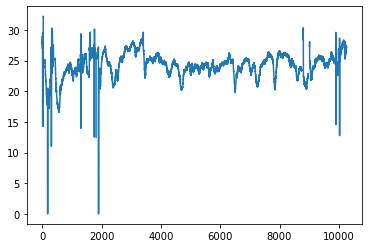

In [10]:
df_de_blinks = df_no_low_conf.copy()
df_de_blinks.Dia_Deblinked.plot()

#### Smoothing

<AxesSubplot:>

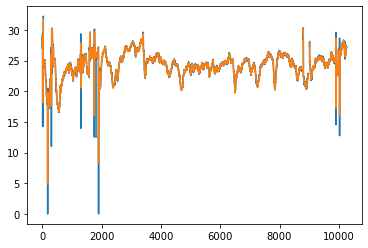

In [11]:
## Smoothing via Moving average or Hanning window.
# Hanning window moving average.
df_hann = df_de_blinks.copy()
df_hann['Dia_Hann'] = df_hann['Dia_Deblinked'].rolling(window=5, center=True, win_type='hann').mean()

# Plot.
df_hann.Dia_Deblinked.plot()
df_hann.Dia_Hann.plot()

<AxesSubplot:>

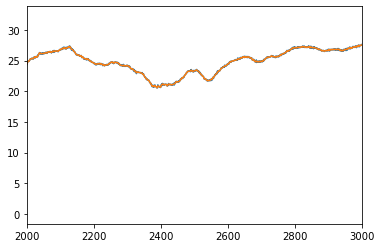

In [12]:
## Check one data portion.
df_hann.Dia_Deblinked.plot(xlim=(2000,3000))
df_hann.Dia_Hann.plot()

#### Interpolation

In [13]:
## Interpolation (linear and spline)
df_interpolate = df_hann.copy()
df_interpolate['Dia_Spline3'] = df_interpolate['Dia_Hann'].interpolate(method='spline',order=3)
df_interpolate['Dia_Linear'] = df_interpolate['Dia_Hann'].interpolate(method='linear') # piecewise and linear look almost the same
df_interpolate['Dia_Cubic'] = df_interpolate['Dia_Hann'].interpolate(method='cubic')
df_interpolate['Dia_PiecewisePoly'] = df_interpolate['Dia_Hann'].interpolate(method='piecewise_polynomial')

<AxesSubplot:>

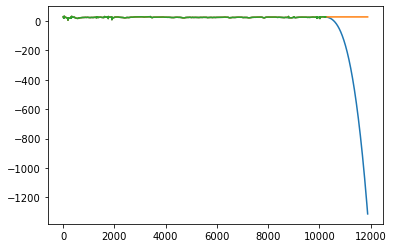

In [14]:
# Plot and see the curves.
# Initialize boundaries.
# xlim_low = 0
# xlim_high = 3000
# ylim_low = 10
# ylim_high = 35

# df_interpolate.Dia_Spline3.plot(xlim=(xlim_low,xlim_high),ylim=(ylim_low,ylim_high))
df_interpolate.Dia_Spline3.plot() # Feels this interpolation tactic is better.
df_interpolate.Dia_Linear.plot()
df_interpolate.Dia_Hann.plot()
# df_interpolate.Dia_Cubic.plot()
# df_interpolate.Dia_PiecewisePoly.plot()  # This seems good as well. Transitions are smooth and natural.

### Artifact rejection

In [15]:
## This part is directly cited from Sam's work.

# Filtering outliers 
# Lan et al. 2020 - median filter with sliding window of 10s
# Testing with numba optimised for-loop implementation of a Hampel Filter
# Note to self: I think this filter is also commonly used for pupil diameter filtering

@jit(nopython=True)
def hampel_filter_forloop_numba(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    indices = []
    
    for i in range((window_size),(n - window_size)):
        x0 = np.nanmedian(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.nanmedian(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

In [16]:
df_outlier_reject = df_interpolate.copy()

x_SP3, outlier_x_SP3 = hampel_filter_forloop_numba(df_outlier_reject.Dia_Spline3.to_numpy(), 10) #applying hampel filter with win size 10
x_L, outlier_x_L = hampel_filter_forloop_numba(df_outlier_reject.Dia_Linear.to_numpy(), 10)
df_outlier_reject['Dia_Spline3_Ham'] = x_SP3.tolist()
df_outlier_reject['Dia_Linear_Ham'] = x_L.tolist()

<AxesSubplot:>

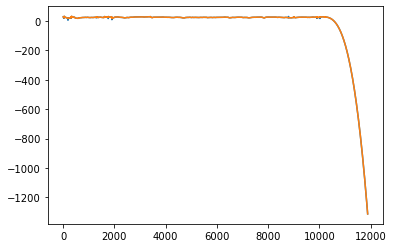

In [17]:
# Test spline curve.
df_outlier_reject.Dia_Spline3.plot()
df_outlier_reject.Dia_Spline3_Ham.plot()

<AxesSubplot:>

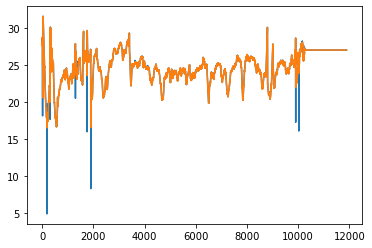

In [18]:
# Test linear curve.
df_outlier_reject.Dia_Linear.plot()
df_outlier_reject.Dia_Linear_Ham.plot()

### Baseline correction (subtractive)

In [19]:
df_baseline_corr = df_outlier_reject.copy()
df_baseline = df_baseline_corr[(df_outlier_reject.Event == 'default')]
df_baseline

,Timestamp,Confidence,Diameter,Event,Blink_marks,Dia_Deblinked,Dia_Hann,Dia_Spline3,Dia_Linear,Dia_Cubic,Dia_PiecewisePoly,Dia_Spline3_Ham,Dia_Linear_Ham
0,424859.221620,0.619354,27.031742,default,1.0,27.031742,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,424859.233974,0.549891,27.787770,default,1.0,27.787770,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,424859.242680,0.626268,28.112017,default,1.0,28.112017,27.880166,27.880166,27.880166,27.880166,27.880166,27.880166,27.880166
3,424859.253524,0.592996,27.508861,default,1.0,27.508861,27.681172,27.681172,27.681172,27.681172,27.681172,27.681172,27.681172
4,424859.269089,0.621343,27.594951,default,1.0,27.594951,27.647097,27.647097,27.647097,27.647097,27.647097,27.647097,27.647097
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492,424874.289375,0.963971,24.700532,default,1.0,24.700532,24.659731,24.659731,24.659731,24.659731,24.659731,24.659731,24.659731
1493,424874.298534,0.919437,24.485846,default,1.0,24.485846,24.612793,24.612793,24.612793,24.612793,24.612793,24.612793,24.612793
1494,424874.309159,0.929921,24.778951,default,1.0,24.778951,24.683713,24.683713,24.683713,24.683713,24.683713,24.683713,24.683713
1495,424874.319911,0.981321,24.691106,default,1.0,24.691106,24.640375,24.640375,24.640375,24.640375,24.640375,24.640375,24.640375


In [20]:
base_median = df_baseline.Dia_Spline3_Ham.median()
df_baseline_corr['Dia_Spline3_Base'] = df_baseline_corr['Dia_Spline3_Ham'] - base_median
# df_baseline_corr['Dia_Spline3_Base'] = df_baseline_corr['Dia_Spline3_Ham'] / base_median
df_baseline_corr

,Timestamp,Confidence,Diameter,Event,Blink_marks,Dia_Deblinked,Dia_Hann,Dia_Spline3,Dia_Linear,Dia_Cubic,Dia_PiecewisePoly,Dia_Spline3_Ham,Dia_Linear_Ham,Dia_Spline3_Base
0,424859.221620,0.619354,27.031742,default,1.0,27.031742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,424859.233974,0.549891,27.787770,default,1.0,27.787770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,424859.242680,0.626268,28.112017,default,1.0,28.112017,27.880166,27.880166,27.880166,27.880166,27.880166,27.880166,27.880166,4.479972
3,424859.253524,0.592996,27.508861,default,1.0,27.508861,27.681172,27.681172,27.681172,27.681172,27.681172,27.681172,27.681172,4.280978
4,424859.269089,0.621343,27.594951,default,1.0,27.594951,27.647097,27.647097,27.647097,27.647097,27.647097,27.647097,27.647097,4.246902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11882,424974.967029,NaN,NaN,sitting,1.0,NaN,NaN,-1303.348625,27.056974,NaN,NaN,-1303.348625,27.056974,-1326.748819
11883,424974.974336,NaN,NaN,sitting,1.0,NaN,NaN,-1305.527799,27.056974,NaN,NaN,-1305.527799,27.056974,-1328.927994
11884,424974.985883,NaN,NaN,sitting,1.0,NaN,NaN,-1307.709339,27.056974,NaN,NaN,-1307.709339,27.056974,-1331.109534
11885,424974.996229,NaN,NaN,sitting,1.0,NaN,NaN,-1309.893246,27.056974,NaN,NaN,-1309.893246,27.056974,-1333.293440


<AxesSubplot:>

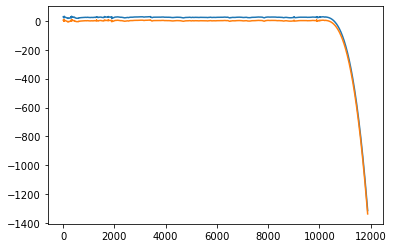

In [21]:
# Test with plots.
df_baseline_corr.Dia_Spline3_Ham.plot()
df_baseline_corr.Dia_Spline3_Base.plot()

This part's events need to be changed.

In [22]:
# Split data according to different events. Return one-d arrays that could be directly processed later.
# df_diameter_default = df_baseline_corr[(df_baseline_corr.Event == 'default')].Dia_Spline3_Base.copy()
df_diameter_sitting = df_baseline_corr[(df_baseline_corr.Event == 'sitting')].copy()
# df_diameter_reading_sitting = df_baseline_corr[(df_baseline_corr.Event == 'reading-sitting')].Dia_Spline3_Base.copy()

In [23]:
df_diameter_sitting

,Timestamp,Confidence,Diameter,Event,Blink_marks,Dia_Deblinked,Dia_Hann,Dia_Spline3,Dia_Linear,Dia_Cubic,Dia_PiecewisePoly,Dia_Spline3_Ham,Dia_Linear_Ham,Dia_Spline3_Base
1497,424874.339393,0.945179,24.153112,sitting,1.0,24.153112,24.269717,24.269717,24.269717,24.269717,24.269717,24.269717,24.269717,0.869523
1498,424874.348411,0.992244,24.372305,sitting,1.0,24.372305,24.264977,24.264977,24.264977,24.264977,24.264977,24.264977,24.264977,0.864783
1499,424874.359277,0.931043,24.162186,sitting,1.0,24.162186,24.151644,24.151644,24.151644,24.151644,24.151644,24.151644,24.151644,0.751450
1500,424874.369923,0.969277,23.909900,sitting,1.0,23.909900,23.997433,23.997433,23.997433,23.997433,23.997433,23.997433,23.997433,0.597239
1501,424874.381294,0.925457,24.007749,sitting,1.0,24.007749,23.990104,23.990104,23.990104,23.990104,23.990104,23.990104,23.990104,0.589910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11882,424974.967029,NaN,NaN,sitting,1.0,NaN,NaN,-1303.348625,27.056974,NaN,NaN,-1303.348625,27.056974,-1326.748819
11883,424974.974336,NaN,NaN,sitting,1.0,NaN,NaN,-1305.527799,27.056974,NaN,NaN,-1305.527799,27.056974,-1328.927994
11884,424974.985883,NaN,NaN,sitting,1.0,NaN,NaN,-1307.709339,27.056974,NaN,NaN,-1307.709339,27.056974,-1331.109534
11885,424974.996229,NaN,NaN,sitting,1.0,NaN,NaN,-1309.893246,27.056974,NaN,NaN,-1309.893246,27.056974,-1333.293440


### Export data to csv for processing

In [24]:
# df_export = df_baseline_corr[['Dia_Spline3_Base', 'Event']].copy()
df_export = df_diameter_sitting[['Dia_Spline3_Base', 'Event']].copy()

# Get rid of the nan values.
df_export = df_export.dropna()
df_export

,Dia_Spline3_Base,Event
1497,0.869523,sitting
1498,0.864783,sitting
1499,0.751450,sitting
1500,0.597239,sitting
1501,0.589910,sitting
...,...,...
11882,-1326.748819,sitting
11883,-1328.927994,sitting
11884,-1331.109534,sitting
11885,-1333.293440,sitting


In [25]:
# Export data.
file_name = read_left_file_path.split('/')[-2:]

folder_path = '../Data/PreprocessedData/' + file_name[0] + '/'
if os.path.exists(folder_path) is False:
    os.makedirs(folder_path)

write_file_name = 'preprocessed_' + str(SR) + 'Hz.csv'
write_file_path = folder_path + write_file_name
df_export.to_csv(write_file_path)

In [26]:
# # Store the file name to be used in computing file.
# %store write_file_path

# # Store the sampling rate to be used in the computing file.
# %store SAMPLING_RATE

In [27]:
# # Run the algorithm from the specific file.
# %run ./PreprocessedPupilDataIPAComputing.ipynb

In [28]:
# df_nor_ts

In [29]:
# lhipa  # Directly access to the target data.

### Sliding window and dynamic LHIPA computing
In this section I implemented a naive sliding window technique to simulate data processing in the real-time setting.

In [30]:
# Interactive part - parameter configuration
len_time_window = 10  # The unit is second.
window_size = len_time_window * SAMPLING_RATE  # The rough allocation of the number of items in a window.
stride = 1
df_rolling = df_export.copy()

In [31]:
df_rolling

,Dia_Spline3_Base,Event
1497,0.869523,sitting
1498,0.864783,sitting
1499,0.751450,sitting
1500,0.597239,sitting
1501,0.589910,sitting
...,...,...
11882,-1326.748819,sitting
11883,-1328.927994,sitting
11884,-1331.109534,sitting
11885,-1333.293440,sitting


In [32]:
## LHIPA algorithm
## Normalize the timestamp into a even serial.
def normalize_timestamp(df, sr):
    runner = 0
    for i in range(len(df)):
        df.loc[i, ('Timestamp')] = runner / sr  # The sampling rate is allocated dynamically.
        runner += 1
    return df

## This algorithm is directly copied from work: The Low/High Index of Pupillary Activity,https://dl.acm.org/doi/pdf/10.1145/3313831.3376394.

# Find the maximum modulus.
def modmax(d):
    # Compute signal modulus.
    m = [0.0] * len(d)
    for i in range(len(d)):
        m[i] = math.fabs(d[i])

    # If value is larger than both neighbours , and strictly larger than either , then it is a local maximum.
    t = [0.0] * len(d)

    for i in range(len(d)):
        ll = m[i - 1] if i >= 1 else m[i]
        oo = m[i]
        rr = m[i + 1] if i < len(d) - 2 else m[i]

        if (ll <= oo and oo >= rr) and (ll < oo or oo > rr):
            # compute magnitude
            t[i] = math.sqrt(d[i] ** 2)
        else:
            t[i] = 0.0
    return t

# Calculate L/H IPA.
def calc_lhipa(d, tt):
    """
    Here d is a dataframe.
    """
    # Initialize parameter.
    wavelet = 'sym16'
    
    # Find max decomposition level.
    w = pywt.Wavelet(wavelet)
    maxlevel = pywt.dwt_max_level(len(d), filter_len=w.dec_len)

    # Set high and low frequency band indeces.
    hif, lof = 1, int(maxlevel / 2)

    # Get detail coefficients of pupil diameter signal d.
    cD_H = pywt.downcoef('d', d, wavelet, 'per', level=hif)
    cD_L = pywt.downcoef('d', d, wavelet, 'per', level=lof)
#     cD_H = pywt.downcoef('d', d['Diameter'], wavelet, 'per', level=hif)
#     cD_L = pywt.downcoef('d', d['Diameter'], wavelet, 'per', level=lof)

    # Normalize by 1/ 2j.
    cD_H[:] = [x / math.sqrt(2 ** hif) for x in cD_H]
    cD_L[:] = [x / math.sqrt(2 ** lof) for x in cD_L]

    # Obtain the LH:HF ratio.
    cD_LH = cD_L
    for i in range(len(cD_L)):
        cD_LH[i] = cD_L[i] / cD_H[((2 ** lof) // (2 ** hif)) * i]   # Used a '//' instead of '/' to make sure the index is an integer.

    # Detect modulus maxima , see Duchowski et al. [15].
    cD_LHm = modmax(cD_LH)

    # Threshold using universal threshold λuniv = σˆ (2logn), where σˆ is the standard deviation of the noise.
    lambda_univ = np.std(cD_LHm) * math.sqrt(2.0*np.log2(len(cD_LHm)))
    cD_LHt = pywt.threshold(cD_LHm, lambda_univ, mode="less")

    # Get signal duration (in seconds).
    # tt = d[-1].timestamp() - d[0].timestamp()
#     tt = d[-1].timestamp - d[0].timestamp
#     tt = d.loc[len(d)-1, ('Timestamp')] - d.loc[0, ('Timestamp')]
    tt = tt

    # Compute LHIPA.
    ctr = 0
    for i in range(len(cD_LHt)):
        if math.fabs(cD_LHt[i]) > 0:
            ctr += 1
    LHIPA = float(ctr) / tt
    return LHIPA

In [33]:
# Convert dataframe into numpy
df_rolling_copy = df_rolling['Dia_Spline3_Base'].copy()
array_data = df_rolling_copy.to_numpy()

# Rolling/Sliding - added a slice method to discretize windows and get rid of overlaps (is this necessary?)
# Reference from https://stackoverflow.com/questions/6811183/rolling-window-for-1d-arrays-in-numpy
windows = sliding_window_view(array_data, window_shape = window_size)[::stride]

# Iterate over windows
lhipas = []
for window in windows:
#     df_window = pd.DataFrame(windows[i], columns = ['Dia_Spline3_Base'])
    lhipa = calc_lhipa(d=np.array(window), tt=len_time_window)
    lhipa = round(lhipa, 4)
    lhipas.append(lhipa)

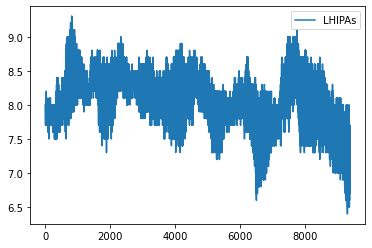

In [34]:
# Plot
fig, ax = plt.subplots()
ax.plot(lhipas)
ax.legend(["LHIPAs"])

In [35]:
print(len(lhipas), np.mean(lhipas))

9371 8.07550955074165
